# IMPORTS AND UTILS

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from sklearn.model_selection import train_test_split
from torchvision import transforms, utils
from torchsummary import summary
from torchvision.models import vgg19
from torch.utils.data import TensorDataset, DataLoader, Dataset
from itertools import product
from PIL import Image
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as PSNR, structural_similarity as SSIM

In [2]:
SEED = 23

In [3]:
def imshow(img):
    plt.figure(figsize=(70, 70))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

class SuperResDataset(Dataset):
    def __init__(self, low_res_paths, high_res_paths, transform=None):
        self.low_res_paths = low_res_paths
        self.high_res_paths = high_res_paths
        self.transform = transform

    def __len__(self):
        return len(self.low_res_paths)

    def __getitem__(self, idx):
        low_res_img = Image.open(self.low_res_paths[idx]).convert("RGB")
        high_res_img = Image.open(self.high_res_paths[idx]).convert("RGB")

        if self.transform:
            low_res_img = self.transform(low_res_img)
            high_res_img = self.transform(high_res_img)

        return low_res_img, high_res_img
    
def trainModel(model, train_loader,criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    metrics = {
        "loss": [],
        "psnr": [],
        "ssim": []
    }
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss, total_psnr, total_ssim = 0.0, 0.0, 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            outputs_np = outputs.detach().cpu().numpy()
            targets_np = targets.detach().cpu().numpy()

            dataRange = 1.0 if targets_np.max() <= 1.0 else 255.0
            batch_psnr = np.mean([PSNR(t, o) for t, o in zip(targets_np, outputs_np)])
            batch_ssim = np.mean([SSIM(t, o, channel_axis=0, data_range=dataRange) for t, o in zip(targets_np, outputs_np)])

            total_psnr += batch_psnr
            total_ssim += batch_ssim

        metrics["loss"].append(running_loss / len(train_loader))
        metrics["psnr"].append(total_psnr / len(train_loader))
        metrics["ssim"].append(total_ssim / len(train_loader))
    return metrics

def evaluateModel(model, testLoader=None, metrics=["mse"]):
    metricValues = {
        "mse": 0.0,
        "psnr": 0.0,
        "ssim": 0.0
    }
    if testLoader is None:
        return metricValues
    model.eval()
    criterion = nn.MSELoss()
    with torch.no_grad():
        for inputs, targets in testLoader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            if "psrn" in metrics or "ssim" in metrics:
                outputs_np = outputs.detach().cpu().numpy()
                targets_np = targets.detach().cpu().numpy()

            if "psnr" in metrics:
                batchPSNR = np.mean([PSNR(t, o) for t, o in zip(targets_np, outputs_np)])
                metricValues["psnr"] += batchPSNR/len(testLoader)

            if "ssim" in metrics:
                dataRange = 1.0 if targets_np.max() <= 1.0 else 255.0
                batchSSIM = np.mean([SSIM(t, o, channel_axis=0, data_range=dataRange) for t, o in zip(targets_np, outputs_np)])
                metricValues["ssim"] += batchSSIM/len(testLoader)

            if "mse" in metrics:
                metricValues["mse"] += loss.item()/len(testLoader)

    return metricValues


# MODELS

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class SRGAN(nn.Module):
    def __init__(self):
        super(SRGAN, self).__init__()
        self.generator = ESPCN(scale_factor=4)
        self.discriminator = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=3//2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=3//2, stride=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=3//2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=3//2, stride=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=3//2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=3//2, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, padding=3//2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=3//2, stride=2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x):
        x = self.generator(x)
        x = self.discriminator(x)
        return x
    
class ESPCN(nn.Module):
    def __init__(self, scale_factor, noOfConvBlocks=2, noOfChannels=64):
        super(ESPCN, self).__init__()
        layers = []
        for idx in range(noOfConvBlocks):
            if idx == 0:
                layers.append(nn.Conv2d(3, noOfChannels, kernel_size=5, padding=5 // 2))
                layers.append(nn.Tanh())
            else:
                layers.append(nn.Conv2d(noOfChannels, noOfChannels//2, kernel_size=3, padding=3 // 2))
                layers.append(nn.Tanh())
                noOfChannels //= 2

        self.feature_extraction = nn.Sequential(
            *layers
        )
        self.sub_pixel_conv = nn.Conv2d(int(noOfChannels), 3 * (scale_factor ** 2), kernel_size=3, padding=3//2)
        self.pixel_shuffle = nn.Sequential(
            nn.PixelShuffle(scale_factor),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.feature_extraction(x)
        x = self.sub_pixel_conv(x)
        x = self.pixel_shuffle(x)
        return x

In [5]:
summary(ESPCN(scale_factor=4, noOfConvBlocks=4, noOfChannels=128), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 256, 256]           9,728
              Tanh-2        [-1, 128, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          73,792
              Tanh-4         [-1, 64, 256, 256]               0
            Conv2d-5         [-1, 32, 256, 256]          18,464
              Tanh-6         [-1, 32, 256, 256]               0
            Conv2d-7         [-1, 16, 256, 256]           4,624
              Tanh-8         [-1, 16, 256, 256]               0
            Conv2d-9         [-1, 48, 256, 256]           6,960
     PixelShuffle-10        [-1, 3, 1024, 1024]               0
          Sigmoid-11        [-1, 3, 1024, 1024]               0
Total params: 113,568
Trainable params: 113,568
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/

In [6]:
summary(SRGAN(), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           4,864
              Tanh-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 32, 256, 256]          18,464
              Tanh-4         [-1, 32, 256, 256]               0
            Conv2d-5         [-1, 48, 256, 256]          13,872
      PixelShuffle-6        [-1, 3, 1024, 1024]               0
           Sigmoid-7        [-1, 3, 1024, 1024]               0
             ESPCN-8        [-1, 3, 1024, 1024]               0
            Conv2d-9       [-1, 64, 1024, 1024]           1,792
        LeakyReLU-10       [-1, 64, 1024, 1024]               0
           Conv2d-11         [-1, 64, 512, 512]          36,928
        LeakyReLU-12         [-1, 64, 512, 512]               0
           Conv2d-13        [-1, 128, 512, 512]          73,856
      BatchNorm2d-14        [-1, 128, 5

In [7]:
summary(Autoencoder(), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
           Dropout-6         [-1, 64, 128, 128]               0
            Conv2d-7        [-1, 128, 128, 128]          73,856
              ReLU-8        [-1, 128, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]         147,584
             ReLU-10        [-1, 128, 128, 128]               0
        MaxPool2d-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 256, 64, 64]         295,168
         Upsample-13        [-1, 256, 128, 128]               0
           Conv2d-14        [-1, 128, 1

# DATA CREATION

In [8]:
import os
import csv

def createCSV(root_dirs, csv_file = 'image_paths.csv', augmented=True):
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['lowResPath', 'highResPath'])

        for root_dir in root_dirs:
            low_res_dir = os.path.join(root_dir, 'low_res')
            high_res_dir = os.path.join(root_dir, 'high_res')
            low_res_augmented_dir = os.path.join(root_dir, 'low_res_augmented')
            augmented_dir = os.path.join(root_dir, 'augmented')

            for filename in os.listdir(low_res_dir):
                low_res_path = os.path.join(low_res_dir, filename)
                high_res_path = os.path.join(high_res_dir, filename)
                writer.writerow([low_res_path, high_res_path])

            if augmented:
                for filename in os.listdir(low_res_augmented_dir):
                    low_res_augmented_path = os.path.join(low_res_augmented_dir, filename)
                    augmented_path = os.path.join(augmented_dir, filename)
                    writer.writerow([low_res_augmented_path, augmented_path])

def prepareData(root_dir, data_directories):
    for data_dir in data_directories:
        high_res_dir = os.path.join(root_dir, data_dir, 'high_res')
        low_res_dir = os.path.join(root_dir, data_dir, 'low_res')
        augmented_dir = os.path.join(root_dir, data_dir, 'augmented')
        low_res_augmented_dir = os.path.join(root_dir, data_dir, 'low_res_augmented')

        os.makedirs(low_res_dir, exist_ok=True)

        for filename in os.listdir(high_res_dir):
            high_res_path = os.path.join(high_res_dir, filename)
            low_res_path = os.path.join(low_res_dir, filename)

            if not os.path.exists(low_res_path):
                with Image.open(high_res_path) as img:
                    low_res_img = img.resize((128, 128))
                    low_res_img = low_res_img.resize((256, 256))
                    low_res_img.save(low_res_path)

        os.makedirs(low_res_augmented_dir, exist_ok=True)
        
        for filename in os.listdir(augmented_dir):
            augmented_path = os.path.join(augmented_dir, filename)
            low_res_augmented_path = os.path.join(low_res_augmented_dir, filename)

            if not os.path.exists(low_res_augmented_path):
                with Image.open(augmented_path) as img:
                    low_res_img = img.resize((128, 128))
                    low_res_img = low_res_img.resize((256, 256))
                    low_res_img.save(low_res_augmented_path)

def processImages(dataPaths):
    experiment_folder = "experiment_data"

    for data_path in dataPaths:
        if not os.path.exists(data_path):
            print(f"Directory '{data_path}' does not exist.")
            continue

        experiment_path = os.path.join(data_path, experiment_folder)
        os.makedirs(experiment_path, exist_ok=True)

        high_res_folder = os.path.join(experiment_path, "high_res")
        low_res_folder = os.path.join(experiment_path, "low_res")

        os.makedirs(high_res_folder, exist_ok=True)
        os.makedirs(low_res_folder, exist_ok=True)

        for filename in os.listdir(data_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(data_path, filename)

                high_res_image = Image.open(img_path)

                low_res_image = high_res_image.resize((128, 128), Image.ANTIALIAS)

                high_res_image_resized = low_res_image.resize((256, 256), Image.ANTIALIAS)

                high_res_image_resized_path = os.path.join(high_res_folder, f"{data_path}_{filename}")
                high_res_image_resized.save(high_res_image_resized_path)

                low_res_image_path = os.path.join(low_res_folder, f"{data_path}_{filename}")
                low_res_image.save(low_res_image_path)

        print(f"Processed images in '{data_path}'")


# Main Experiment

In [9]:
class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval())
        for bl in blocks:
            for p in bl.parameters():
                p.requires_grad = False
        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate
        self.resize = resize
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, input, target, feature_layers=[0, 1, 2, 3], style_layers=[]):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for i, block in enumerate(self.blocks):
            x = block(x)
            y = block(y)
            if i in feature_layers:
                loss += torch.nn.functional.l1_loss(x, y)
            if i in style_layers:
                act_x = x.reshape(x.shape[0], x.shape[1], -1)
                act_y = y.reshape(y.shape[0], y.shape[1], -1)
                gram_x = act_x @ act_x.permute(0, 2, 1)
                gram_y = act_y @ act_y.permute(0, 2, 1)
                loss += torch.nn.functional.l1_loss(gram_x, gram_y)
        return loss

In [10]:
MODELS = {"espcn": ESPCN, "srgan": SRGAN}
LOSSFUNCTIONS = {
    "mse": nn.MSELoss(),
    "mae": nn.L1Loss(),
    "vgg": VGGPerceptualLoss()
}
OPTIMIZERS = {
    "adam": torch.optim.Adam,
    "sgd": torch.optim.SGD,
    "rmsprop": torch.optim.RMSprop
}

c:\Users\tymon\OneDrive\Pulpit\University\Sem5\ComputerVision\Labs\Project3\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tymon\OneDrive\Pulpit\University\Sem5\ComputerVision\Labs\Project3\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
prepareData('', ['data/Own/'])
prepareData('', ['data/ISR/raw_data'])
createCSV(['data/ISR/raw_data', 'data/Own'], 'image_paths.csv', augmented=False)

imagePaths = pd.read_csv('image_paths.csv')
lowResPaths = imagePaths['lowResPath'].tolist()
highResPaths = imagePaths['highResPath'].tolist()

trainLowResPaths, testLowResPaths, trainHighResPaths, testHighResPaths = train_test_split(lowResPaths, highResPaths, test_size=0.2, random_state=SEED)

trainLowResPaths, valLowResPaths, trainHighResPaths, valHighResPaths = train_test_split(trainLowResPaths, trainHighResPaths, test_size=0.1, random_state=SEED)

print("Train set shape (High-Res):", len(trainHighResPaths))
print("Train set shape (Low-Res):", len(trainLowResPaths))
print("Validation set shape (High-Res):", len(valHighResPaths))
print("Validation set shape (Low-Res):", len(valLowResPaths))
print("Test set shape (High-Res):", len(testHighResPaths))
print("Test set shape (Low-Res):", len(testLowResPaths))

transform = transforms.Compose([transforms.ToTensor()])

trainDataset = SuperResDataset(trainLowResPaths, trainHighResPaths, transform=transform)
trainLoader = DataLoader(trainDataset, batch_size=1, shuffle=True)

valDataset = SuperResDataset(valLowResPaths, valHighResPaths, transform=transform)
valLoader = DataLoader(valDataset, batch_size=1, shuffle=True)

testDataset = SuperResDataset(testLowResPaths, testHighResPaths, transform=transform)
testLoader = DataLoader(testDataset, batch_size=1, shuffle=True)


Train set shape (High-Res): 730
Train set shape (Low-Res): 730
Validation set shape (High-Res): 82
Validation set shape (Low-Res): 82
Test set shape (High-Res): 203
Test set shape (Low-Res): 203


## DATA AUGMENTATION

In [12]:
def augment_images(directories):
    for directory in directories:
        high_res_folder = os.path.join(directory, "high_res")
        augmented_folder = os.path.join(directory, "augmented")

        if not os.path.exists(augmented_folder):
            os.makedirs(augmented_folder)

        if not os.path.exists(high_res_folder):
            print(f"High-resolution folder not found in {directory}")
            continue

        for filename in os.listdir(high_res_folder):
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(high_res_folder, filename)
                img = Image.open(image_path)

                augmented_images = perform_augmentations(img)

                for augmentation_suffix, augmented_img in augmented_images.items():
                    augmented_filename = f"{os.path.splitext(filename)[0]}_{augmentation_suffix}{os.path.splitext(filename)[1]}"
                    augmented_path = os.path.join(augmented_folder, augmented_filename)
                    
                    if not os.path.exists(augmented_path):
                        augmented_img.save(augmented_path)


def perform_augmentations(image):
    augmented_images = {
        "rotation": image.rotate(45), 
        "transpose": image.transpose(Image.FLIP_LEFT_RIGHT)
    }

    return augmented_images

directories_to_process = ["data/Own/", "data/ISR/raw_data"]
augment_images(directories_to_process)

## Hyperparameter tuning
Performed only on ESPCN model with MSE loss function and Adam optimizer.<br>
The architercture consists of 2 convolution blocks and 64 channels as the first filter.

In [ ]:
def hyperparameterTuning(valTrainLoader, valTestLoader, learningRates, L2RegularizationValues, noOfConvBlocks, noOfChannels):
    bestHyperparameters = None
    bestValSSIM = float('-inf')

    for lr, l2Reg, noOfConvBlocks, noOfChannels in product(learningRates, L2RegularizationValues, noOfConvBlocks, noOfChannels):
        print(f"lr: {lr}, l2_reg: {l2Reg}, noOfConvBlocks: {noOfConvBlocks}, noOfChannels: {noOfChannels}")

        model = ESPCN(scale_factor=1, noOfConvBlocks=noOfConvBlocks, noOfChannels=noOfChannels)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2Reg)
        criterion = nn.MSELoss()

        trainModel(model, valTrainLoader, criterion, optimizer, num_epochs=2)

        valSSIM = evaluateModel(model, valTestLoader, ["ssim"])["ssim"]
        print(f"Validation Loss: {valSSIM}")

        if valSSIM > bestValSSIM:
            bestValSSIM = valSSIM
            bestHyperparameters = {"lr": lr, "l2Reg": l2Reg, "noOfConvBlocks": noOfConvBlocks, "noOfChannels": noOfChannels}



    print(f"Best hyperparameters: {bestHyperparameters}")
    return bestHyperparameters

learningRates = [0.01, 0.001, 0.0001]
L2RegularizationValues = [0.01, 0.001, 0.0001]
noOfConvBlocks = [2, 3, 4]
noOfChannels = [64, 128, 256]

BESTPARAMETERS = hyperparameterTuning(trainLoader, valLoader, learningRates, L2RegularizationValues, noOfConvBlocks, noOfChannels)

## Training
Done with K-Fold cross-validation

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset

BESTPARAMS = {
    "lr": 0.001,
    "l2Reg": 0.001,
    "noOfConvBlocks": 2,
    "noOfChannels": 64
}

def trainKFold(noOfFolds=5, bestParams=BESTPARAMS, optimizer=torch.optim.Adam, lossFunction=nn.MSELoss, model = ESPCN):
    trainingResults = {}
    validationResults = {}

    kf = KFold(n_splits=noOfFolds, shuffle=True, random_state=SEED)
    noOfSamples = len(trainDataset)

    for fold, (trainIndicies, valIndicies) in enumerate(kf.split(np.arange(noOfSamples))):
        print(f"Fold: {fold+1}/{noOfFolds}")

        trainLoader = DataLoader(Subset(trainDataset, trainIndicies), batch_size=1, shuffle=True)
        valLoader = DataLoader(Subset(trainDataset, valIndicies), batch_size=1, shuffle=True)

        if model == ESPCN:
            modelFold = model(scale_factor=1)
        criterionFold = lossFunction()
        optimizerFold = optimizer(modelFold.parameters(), lr=bestParams['lr'], weight_decay=bestParams['l2Reg'])

        metrics = trainModel(modelFold, trainLoader, criterionFold, optimizerFold, num_epochs=10)

        trainingResults[fold+1] = metrics
        validationResults[fold+1] = evaluateModel(modelFold, valLoader, ["ssim"])
    # torch.save(modelFold.state_dict(), 'models/espcn_model_full_not_augmented.pth')
        
    return trainingResults, validationResults

TRAINING_RESULTS, VALIDATION_RESULTS = trainKFold(noOfFolds=5, bestParams=BESTPARAMS)


In [15]:
modelTest = ESPCN(scale_factor=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(modelTest.parameters(), lr=0.001)
metrics = trainModel(modelTest, trainLoader, criterion, optimizer, num_epochs=10)
torch.save(modelTest.state_dict(), 'models/espcn_model_full_Working.pth')

100%|██████████| 10/10 [09:56<00:00, 59.66s/it]


# PREDICTING

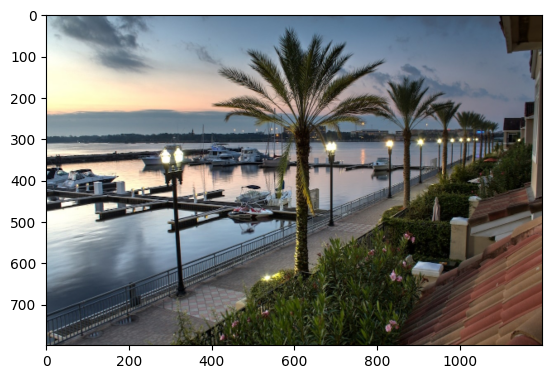

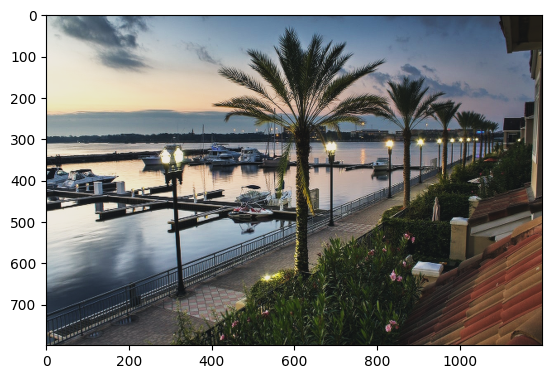

In [28]:
transform = transforms.Compose([transforms.ToTensor()])

model = ESPCN(scale_factor=1)
model.load_state_dict(torch.load('models/espcn_model_full_Working.pth'))

model.eval()
# testImage = Image.open('data/ISR/raw_data/low_res/220.png').convert("RGB")
# testImage = Image.open('data/Own/low_res/000100.png').convert("RGB")
testImage = Image.open('data/Unsplash/low_res/11_2.jpg').convert("RGB")

plt.imshow(testImage)
plt.show()


test_input = transform(testImage)
with torch.no_grad():
    predicted_output = model(test_input)
img = predicted_output.detach().numpy()
img = np.transpose(img, (1, 2, 0))

plt.imshow(img)
plt.show()